# Fully Bayesian GPs - Sampling Hyperparamters with NUTS

In this notebook, we'll demonstrate how to integrate GPyTorch and NUTS to sample GP hyperparameters and perform GP inference in a fully Bayesian way.

The high level overview of sampling in GPyTorch is as follows:

1. Define your model as normal, extending ExactGP and defining a forward method.
2. For each parameter your model defines, you'll need to register a GPyTorch prior with that parameter, or some function of the parameter. If you use something other than a default closure (e.g., by specifying a parameter or transformed parameter name), you'll need to also specify a setting_closure: see the docs for `gpytorch.Module.register_prior`.
3. Define a pyro model that has a sample site for each GP parameter, and then computes a loss. For your convenience, we define a `pyro_sample_from_prior` method on `gpytorch.Module` that does the former operation. For the latter operation, just call `mll.pyro_factor(output, y)` instead of `mll(output, y)` to get your loss.
4. Run NUTS (or HMC etc) on the pyro model you just defined to generate samples. Note this can take quite a while or no time at all depending on the priors you've defined.
5. Load the samples in to the model, converting the model from a simple GP to a batch GP (see our example notebook on simple batch GPs), where each GP in the batch corresponds to a different hyperparameter sample.
6. Pass test data through the batch GP to get predictions for each hyperparameter sample.

In [1]:
import math
import torch
import gpytorch
import pyro
from pyro.infer.mcmc import NUTS, MCMC
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [2]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [3]:
def generate_data(nx=200, split=150):
    full_x = torch.linspace(-15., 15., nx)#.cuda()

    sinc = lambda x: torch.sin(math.pi * x) / (math.pi * x)
    sinc_testfn = lambda x: sinc(x) + sinc(x - 10.) + sinc(x + 10.)

    full_y = sinc_testfn(full_x)

    train_set = ~((full_x > -4.5) * (full_x < 4.5))
    train_x = full_x[train_set]
    train_y = full_y[train_set]

    test_x = full_x[~train_set]
    test_y = full_y[~train_set]

    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = generate_data(2000, 1500)


In [4]:
# We will use the simplest form of GP model, exact inference
class SpectralGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.keops.SpectralGPKernel(train_x, register_latent_params=True)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Mean, covar, likelihood
        self.mean_module = gpytorch.means.QuadraticMean(input_size = 1, 
                        raw_quadratic_weights_constraint=gpytorch.constraints.LessThan(0.0),
                        raw_bias_constraint=gpytorch.constraints.Positive(), use_weights=False,
                        bias_prior=gpytorch.priors.LogNormalPrior(0., 0.3))
        
        # why am i doing this 
        def custom_setter(x):
            self.mean_module.initialize(**{'quadratic_weights': -x})
        self.mean_module.register_prior('quadratic_weights_prior',
                                       gpytorch.priors.LogNormalPrior(0., 0.3),
                                       lambda: -self.mean_module.quadratic_weights,
                                       custom_setter
                                       )
        self.mean_module.quadratic_weights = -10.
        self.mean_module.bias = 1.

        self.covar_module = gpytorch.kernels.ScaleKernel(
                                gpytorch.kernels.MaternKernel(nu=1.5, 
                                    lengthscale_prior=gpytorch.priors.LogNormalPrior(0., 0.3)),
                                    outputscale_prior=gpytorch.priors.LogNormalPrior(0., 0.3),
                        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_samples = 2 if smoke_test else 10
warmup_steps = 2 if smoke_test else 50

In [6]:
from gpytorch.priors import LogNormalPrior, NormalPrior, UniformPrior
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
model = SpectralGPModel(train_x, train_y, likelihood)

model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")
likelihood.register_prior("noise_prior", UniformPrior(1e-3, 0.3), "noise")

In [7]:
latent_lh = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
latent_lh.register_prior("latent_noise_prior", UniformPrior(1e-5, 1e-4), "noise")

latent_gp = ExactGPModel(model.covar_module.omega, model.covar_module.omega, latent_lh)
model.covar_module.register_prior("latent_gp_prior", gpytorch.priors.GaussianProcessPrior(latent_gp),
                                 "latent_params")


## Running Sampling

The next cell is the first piece of code that differs substantially from other work flows. In it, we create the model and likelihood as normal, and then register priors to each of the parameters of the model. Note that we directly can register priors to transformed parameters (e.g., "lengthscale") rather than raw ones (e.g., "raw_lengthscale"). This is useful, **however** you'll need to specify a prior whose support is fully contained in the domain of the parameter. For example, a lengthscale prior must have support only over the positive reals or a subset thereof.

In [8]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def pyro_model(x, y):
    model.pyro_sample_from_prior()
    output = model(x)
    loss = mll.pyro_factor(output, y)
    return y

nuts_kernel = NUTS(pyro_model, adapt_step_size=True, step_size=0.01)
mcmc_run = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=False)
mcmc_run.run(train_x, train_y)

Warmup:   2%|▏         | 1/60 [00:00,  1.99it/s, step size=7.19e-02, acc. prob=1.000]/home/wesley/Documents/Code/wjm_gpytorch/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm nan which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)
Sample: 100%|██████████| 60/60 [21:51, 21.85s/it, step size=1.26e-03, acc. prob=0.761]


## Loading Samples

In the next cell, we load the samples generated by NUTS in to the model. This converts `model` from a single GP to a batch of `num_samples` GPs, in this case 100.

In [9]:
model.pyro_load_from_samples(mcmc_run.get_samples())

In [16]:
full_x = torch.cat((train_x, test_x))
print(full_x.shape)

torch.Size([2000])


In [17]:
model.eval()
expanded_test_x = full_x.unsqueeze(-1).unsqueeze(0).repeat(num_samples, 1, 1)
output = model(expanded_test_x)

Compiling libKeOpstorch3b12bbe214 in /home/wesley/.cache/pykeops-1.3-cpython-37/build-libKeOpstorch3b12bbe214:
       formula: Sum_Reduction((Sum((((Extract((Cos(((Var(0,1,0) - Var(1,1,1)) * Var(2,50,2))) * Var(3,50,2)),1,49) + Extract((Cos(((Var(0,1,0) - Var(1,1,1)) * Var(2,50,2))) * Var(3,50,2)),0,49)) / Var(4,1,2)) * Var(5,49,2))) * Var(6,1400,1)),0)
       aliases: Var(0,1,0); Var(1,1,1); Var(2,50,2); Var(3,50,2); Var(4,1,2); Var(5,49,2); Var(6,1400,1); 
       dtype  : float32
... Done.
Compiling libKeOpstorchdbe54930b8 in /home/wesley/.cache/pykeops-1.3-cpython-37/build-libKeOpstorchdbe54930b8:
       formula: Sum_Reduction((Sum((((Extract((Cos(((Var(0,1,0) - Var(1,1,1)) * Var(2,50,2))) * Var(3,50,2)),1,49) + Extract((Cos(((Var(0,1,0) - Var(1,1,1)) * Var(2,50,2))) * Var(3,50,2)),0,49)) / Var(4,1,2)) * Var(5,49,2))) * Var(6,2000,1)),0)
       aliases: Var(0,1,0); Var(1,1,1); Var(2,50,2); Var(3,50,2); Var(4,1,2); Var(5,49,2); Var(6,2000,1); 
       dtype  : float32
... Done.


In [18]:
output.mean.shape

torch.Size([10, 2000])

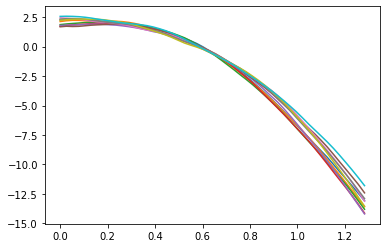

In [19]:
plt.plot(model.covar_module.omega.cpu().numpy(), model.covar_module.latent_params.cpu().detach().numpy().T)

## Plot Mean Functions

In the next cell, we plot the first 25 mean functions on the samep lot. This particular example has a fairly large amount of data for only 1 dimension, so the hyperparameter posterior is quite tight and there is relatively little variance.

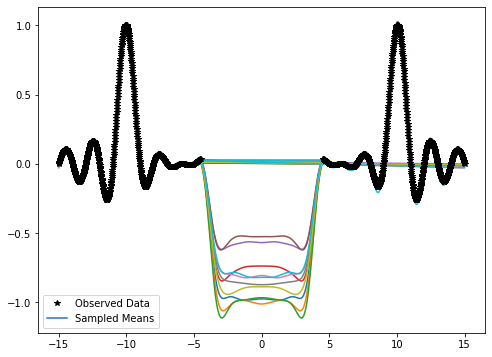

In [28]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Plot training data as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', zorder=10)
    
    for i in range(min(num_samples, 25)):
        # Plot predictive means as blue line
        ax.plot(full_x.cpu().numpy(), output.mean[i].cpu().detach().numpy())
        
    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([-0.4, 1.1])
    ax.legend(['Observed Data', 'Sampled Means'])

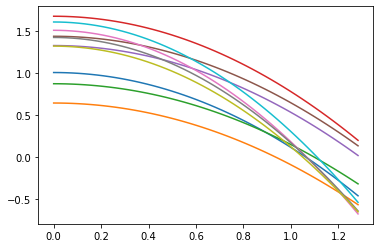

In [27]:
omega = model.covar_module.latent_gp_prior.gp_model.train_inputs[0]
latent_mean = model.covar_module.latent_gp_prior.gp_model.mean_module(omega).detach().cpu()

plt.plot(omega[...,0].cpu().t(), latent_mean.t())